## The Trial Class

`compsyn.trial.Trial` provides a data interface for specifying "experimental metadata". This metadata can be used to logically organize the data generated for a given experiment. 

```python
class Trial:
    def __init__(
        self,
        experiment_name: str,
        trial_id: str,
        hostname: Optional[str],
        trial_timestamp: Optional[str],
        work_dir: Optional[Path],
    ) -> None:
        ...
```

A `Trial` can be used to coordinate an ongoing data collection and analysis effort. For instance, running a timeseries of analysis jobs, or running analysis across multiple hosts. The `Trial` class should be used as a data class, that is - a provider of data only. The attributes of a `Trial` are:

- `experiment_name` is an overarching title for the data collection and analysis effort.

- `trial_id` can be used to further logically partition the data produced for the effort.

- `hostname` (optional) can be used to identify the host the data collection or analysis was run on.

- `trial_timestamp` This will be automatically set to the current date, or any string can be passed.

All of the `Trial` values can be set in the environment like the `CompsynConfig` values, but generally they should be set in code. For example, here we will create a `Trial` object that could be used for participating in a collaborative geolocation-sensitive experiment.

In [1]:
from pathlib import Path

from compsyn.trial import Trial

regional_trial = Trial(
    experiment_name="regional-differences",
    trial_id="phase-0",
    hostname="toronto",
)

[1616905668] (compsyn.Trial)  INFO: experiment: regional-differences
[1616905668] (compsyn.Trial)  INFO: trial_id: phase-0
[1616905668] (compsyn.Trial)  INFO: hostname: toronto


Throughout the rest of this notebook, we will show how this `Trial` class is used throughout compsyn. First, we must introduce the `Vector` base class. The `Vector` base class is expanded on by modality-specific subclasses.

## The Vector Class

`compsyn.vector.Vector` provides a base class for implementing embeddings generated from any sensory input amenable to digitization. The `Vector` base class will provide methods for saving and loading `Vector` subclasses using `pickle`.

```python
class Vector:
    def __init__(
        self, 
        label: str, 
        revision: Optional[str] = None, 
        trial: Optional[Trial] = None
    ) -> None:
```

All `Vector` subclasses will share these attributes:

- `label` A label for the Vector.
- `revision` (optional) A revision tag to associate when saving the vector.
- `trial` A `Trial` object to use as a source of metadata.

All `Vector` subclasses will have access to these methods:

- (property) `vector_pickle_path` returns Path to store vector pickle at.
- `save` Save the object as a pickle file.
- `load` load the object from a pickle file.
- `pull` Optionally pull data from shared S3 backend.
- `push` Optionally push data to shared S3 backend.

`Vector` subclasses, like `WordToColorVector` are left to implement their specific data collection and analysis logic. Subclassers may also extend `pull` and `push` to involve the transfer of more data besides that which is stored on the object.

For ease of use, a default `Trial` object will be created if one is not passed to `Vector` subclassers.

In [2]:
from compsyn.vectors import WordToColorVector
w2cv = WordToColorVector(label="dog")

[1616905668] (compsyn.Trial)  INFO: experiment: default-experiment
[1616905668] (compsyn.Trial)  INFO: trial_id: default-trial
[1616905668] (compsyn.Trial)  INFO: hostname: topside.local


Users may wish to use a specific `Trial` object, like the one created above, so that they can coordinate data collection and analysis efforts over time and across distances. The trial object passed to `Vector` subclassers will be associated with the resulting object for future analysis.

In [3]:
w2cv = WordToColorVector(label="umami", trial=regional_trial)
print(w2cv)

WordToColorVector(umami)
	Trial
		experiment_name = regional-differences
		trial_id        = phase-0
		hostname        = toronto
		trial_timestamp = 2021-03-28
	generated data:
		(raw images available)


The `WordToColorVector` class decides where to hold data by combining attributes of the `Trial` object. The specific logic for "gathering images associated with a word" and "creating an averaged color representation" are left to the `WordToColorVector` class to implement.

In [4]:
urls = w2cv.run_image_capture() # takes ~1-2 minutes to complete

[1616905668] (compsyn.WordToColorVector.umami)  INFO: 99 raw images already downloaded


[1616905674] (compsyn.ImageAnalysis)  INFO: umami is being compressed.

WordToColorVector(umami)
	Trial
		experiment_name = regional-differences
		trial_id        = phase-0
		hostname        = toronto
		trial_timestamp = 2021-03-28
	generated data:
		(raw images available)
		rgb_dist         = ['1.15e-07', '5.48e-09', '5.16e-09', '6.99e-09', '5.11e-08', '2.61e-09', '3.66e-08', '2.60e-07']
		jzazbz_dist      = [8.045, 118.087, 1.368, 143.788, 17.598, 341.576, 6.74, 204.552]
		jzazbz_dist_std  = [29.719, 147.071, 3.743, 116.969, 75.894, 234.381, 43.877, 141.361]


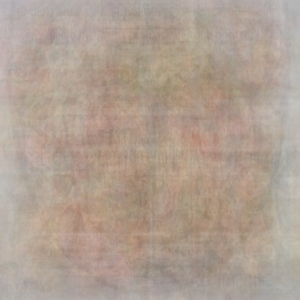

In [5]:
w2cv.run_analysis()
print()
print(w2cv)
w2cv.colorgram

Now, the `WordToColorVector` object has pointers to the raw images gathered, the results of the analysis, as well as the `Trial` associated metadata. All `Vector` subclasses can be saved to and loaded from the python pickle format. This way collaborators can share results using python objects.

In [6]:
w2cv.save()

[1616905674] (compsyn.WordToColorVector.umami)  INFO: saved 264.8KiB pickle to /Volumes/LACIE/compsyn/data/zth/regional-differences/vectors/phase-0-toronto/umami/w2cv.pickle


`WordToColorVector.revision` is not set, so a default revision is created by combining attributes of the associated `Trial` object. The `revision` attribute may be set to any value, which may be useful when playing with different analysis parameters or techniques on the same dataset. In these cases, you may wish to set a specific revision value for the vector before saving it.

With the `Vector` object saved to disk, we can come back to our work later 

[1616905674] (compsyn.load_pickle)  INFO: loaded pickle from /Volumes/LACIE/compsyn/data/zth/regional-differences/vectors/notebook-example-0/umami/w2cv.pickle
WordToColorVector(umami)
	Trial
		experiment_name = regional-differences
		trial_id        = phase-0
		hostname        = toronto
		trial_timestamp = 2021-03-28
	generated data:
		(raw images available)
		rgb_dist         = ['1.17e-07', '5.63e-09', '5.25e-09', '7.26e-09', '4.98e-08', '1.91e-09', '3.60e-08', '2.59e-07']
		jzazbz_dist      = [8.293, 121.865, 1.249, 141.882, 18.229, 343.903, 3.704, 202.629]
		jzazbz_dist_std  = [30.306, 148.933, 3.472, 116.587, 77.407, 235.878, 31.509, 143.873]


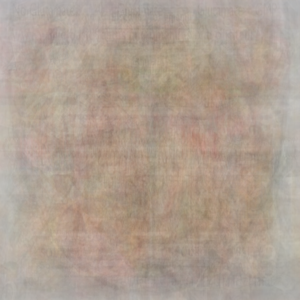

In [7]:
del w2cv # simulate leaving and coming back to our work later

# Re-use the Trial object and revision so that we can find the data
w2cv = WordToColorVector(label="umami", revision="notebook-example-0", trial=regional_trial)
w2cv.load()
print(w2cv)
w2cv.colorgram

# Some attributes may not be stored, to control the saved object size getting too large
# For instance, the larger jzazbz_vector, as well as the ImageData and ImageAnalysis objects are dropped.

The `Vector` class also knows how to store data in a shared backed (Using S3 object storage), but this requires configuration for accessing this backend. Set the following environment variables in the shell running this notebook to enable this feature.

- `COMPSYN_S3_ACCESS_KEY_ID`
- `COMPSYN_S3_SECRET_ACCESS_KEY`
- `COMPSYN_S3_BUCKET`
- `COMPSYN_S3_REGION_NAME`
- (optional) `COMPSYN_S3_ENDPOINT_URL` 

In [8]:
w2cv.push()

[1616905674] (compsyn.WordToColorVector.umami)  INFO: saved 264.8KiB pickle to /Volumes/LACIE/compsyn/data/zth/regional-differences/vectors/notebook-example-0/umami/w2cv.pickle


By default, push does not store raw images, but it can.

In [9]:
w2cv.push(include_raw_images=True)

[1616905675] (compsyn.WordToColorVector.umami)  INFO: saved 264.8KiB pickle to /Volumes/LACIE/compsyn/data/zth/regional-differences/vectors/notebook-example-0/umami/w2cv.pickle
[1616905675] (compsyn.WordToColorVector.umami)  INFO: pushing raw images (ovewrite=False)...
[1616905695] (compsyn.WordToColorVector.umami)  INFO: pushed 99 raw images to remote in 19 seconds


With the raw images stored remotely, we can now regenerate the entire analysis object from the data in S3.

In [10]:
for p in w2cv._local_raw_images_path.iterdir():
    p.unlink() # clear the downloads folder to simulate a fresh pull operation
del w2cv

w2cv = WordToColorVector(label="umami", revision="notebook-example-0", trial=regional_trial)
w2cv.pull(include_raw_images=True)
w2cv.run_analysis()


[1616905695] (compsyn.load_pickle)  INFO: loaded pickle from /Volumes/LACIE/compsyn/data/zth/regional-differences/vectors/notebook-example-0/umami/w2cv.pickle
[1616905695] (compsyn.WordToColorVector.umami)  INFO: pulling raw images (ovewrite=False)...
[1616905710] (compsyn.WordToColorVector.umami)  INFO: pulled 99 raw images from remote in 14 seconds
[1616905714] (compsyn.ImageAnalysis)  INFO: umami is being compressed.



WordToColorVector(umami)
	Trial
		experiment_name = regional-differences
		trial_id        = phase-0
		hostname        = toronto
		trial_timestamp = 2021-03-28
	generated data:
		(raw images available)
		rgb_dist         = ['1.15e-07', '5.48e-09', '5.16e-09', '6.99e-09', '5.11e-08', '2.61e-09', '3.66e-08', '2.60e-07']
		jzazbz_dist      = [8.045, 118.087, 1.368, 143.788, 17.598, 341.576, 6.74, 204.552]
		jzazbz_dist_std  = [29.719, 147.071, 3.743, 116.969, 75.894, 234.381, 43.877, 141.361]


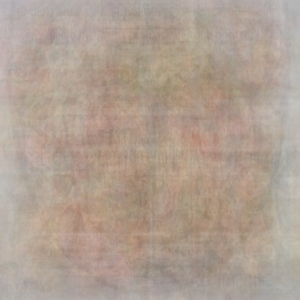

In [11]:
print()
print(w2cv)
w2cv.colorgram

__NOTE__: array values have changed slightly due to the compression used when storing images in S3.

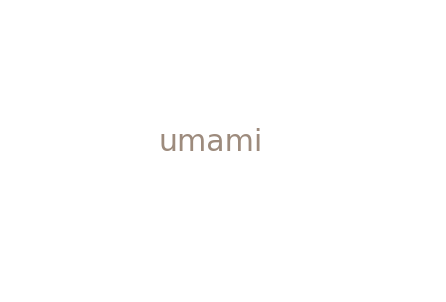

In [12]:
w2cv.print_word_color()